# COGS 118A - Project Checkpoint

### Installing dependencies and importing packages

In [1]:
import numpy as np # for matrix processing
import pandas as pd # for dataframe processing
import matplotlib.pyplot as plt # for plot
from wordcloud import WordCloud, STOPWORDS # for word cloud generator and tag cloud creator
import re
import nltk
# nltk.download('stopwords') # if not yet download the stopwords
stemmer = nltk.SnowballStemmer("english")
# "stopwords" are the most common words in a language that are filtered out before processing
from nltk.corpus import stopwords
import string
stopword=set(stopwords.words('english'))

# Names

Hopefully your team is at least this good. Obviously you should replace these with your names.

- Jason Krentsel
- Jackie Lai
- Shantelle Serafin
- Zecheng (Justin) Li

# Abstract 

Our goal is to categorize text found within tweets as hate speech, offensive language, or being neither. The data set we are using is representative of actual tweets on twitter and are measured by crowd-sourced opinions of which category best fits each tweet. We will be using this data to train an algorithm to determine if tweets contain hate speech and/or offensive language to then determine if it would be appropriate to flag the tweet or ban the user. Performance will be measured based on accuracy of classification.

# Background

Offensive speech and hate speech is prolific on the internet, one could argue that it is more easily found there than in the real world. This abundance could be due to a number of factors, including but not limited to anonymity, invisibility, community, and instantaneousness<a name="brown"></a>[<sup>[1]</sup>](#brownnote). Because of the anonymity and real physical distance between speaker and recipient, the internet has become a place where it is safe, and sometimes even encouraged, to engage in hate culture as there are much fewer real-world repercussions. Resultantly, social media companies are facing lots of criticism and backlash from governments, causing them to be more “proactive in anticipating corrupted use of their online platforms.” <a name="ulgen"></a>[<sup>[2]</sup>](#ulgennote) However, the “constantly evolving nature of and variety of cyberhate”<a name="brown"></a>[<sup>[1]</sup>](#brownnote) makes this not only practically difficult but could potentially lead to misflagging of tweets or accounts.

# Problem Statement

The problem we are solving is the classification of Tweets into 2 or 3 different categories: hate speech, offensive language, or neither. We want to develop a machine learning model that can accurately predict a novel tweets class for possible use in automatically moderating the site. One of the more complex parts of creating such a model is turning text into quantitative data. While this is far from impossible, there are many natural language processing techniques we can utilize which can maintain varying amounts of semantic information. After tokenizing a tweet, we can use a Term Frequency-Inverse Document Frequency (TF-IDF) strategy to generate a value of how important each word is to a tweet. This is quite a powerful technique because not all offensive tweets are hateful. For example, “I f***ing love this movie” would obviously be flagged for offensive language, but the importance of the offensive word is low and could signify non-hateful meaning. On the other hand, hateful language doesn’t necessarily have to have offensive content, ex. “I think the director of this movie should never show their face in public after that terrible movie”. The main error metric we want to use is false positive rate. As this would be an automatic moderating system, we want to only allow it to ban users only when it is very sure that their tweets are offensive or hateful. We can use a more lenient system for flagging tweets for human moderation where our model might miss, but it would not be good for it to accidentally ban users that did not post malicious content. Malicious text content on the internet is arguably some of the most replicable data there can be. There is a constant flow of tweets being published, and even when they are not neatly organized in a dataset, we can always utilize Twitter’s API to scrape for more data.

# Data

- https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset
- 24784 observations, with 7 variables
- An observation consists of [count of human classifier votes, hate speech votes, offensive language votes, neither votes, final classification (plural vote), tweet text]
- The main critical variables is the final classification and the raw tweet text
- We will need to use various natural language processing techniques to turn the raw tweet text into quantifiable values. We will most likely utilize bag-of-words and Term Frequency-Inverse Document Frequency to convert this text data into numerical values.


In [2]:
df = pd.read_csv('labeled_data.csv')
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [3]:
df['class'].unique()

array([2, 1, 0])

Class label for majority of CF users:
 0 - hate speech
 1 - offensive language
 2 - neither

In [4]:
df[['tweet', 'class']]

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1
...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,1
24779,"you've gone and broke the wrong heart baby, an...",2
24780,young buck wanna eat!!.. dat nigguh like I ain...,1
24781,youu got wild bitches tellin you lies,1


In [5]:
df['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

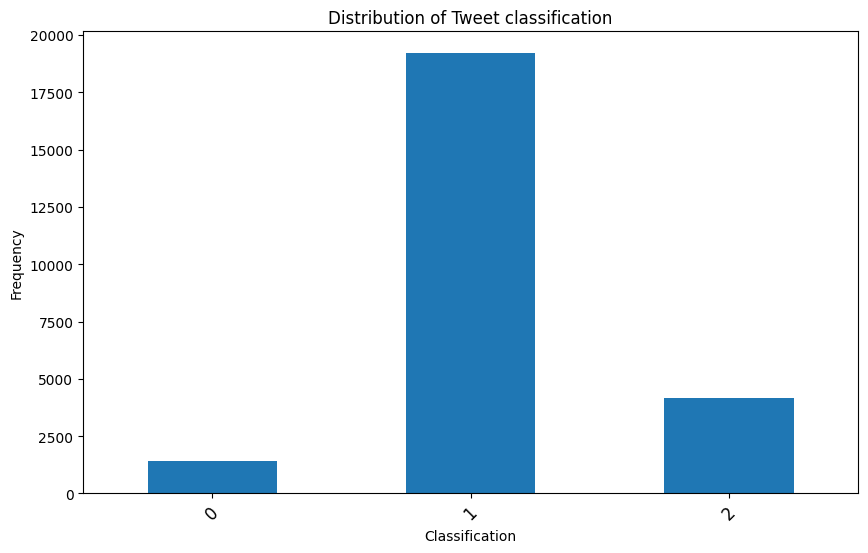

In [6]:
class_dis = df['class'].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(10, 6))
class_dis.plot(kind='bar')
plt.title('Distribution of Tweet classification')
plt.xlabel('Classification')
plt.xticks(fontsize=12, rotation=45)
plt.ylabel('Frequency')
plt.show()

### Data description
It’s important to note that the data we have has a large imbalance of tweet labels between hate speech (0), offensive language (1), and neither (2). The majority of the data is labeled 1. Thus, this may cause the model to have a bias to classify a tweet as offensive. In order to combat this challenge, we plant split the data evenly during training to ensure that the model is not biased towards one classification. Moreover, we may consider enlargement for the 0 and 2 classes. In the cells below we generated word clouds to showcase the most common words in each class.

In [7]:
def generate_wordcloud(tweets):
    # Join all the tweets together into one long string
    long_string = ' '.join(tweets)
    # set stopwords
    stopwords = set(STOPWORDS)
    stopwords.add("RT")

    # Create a WordCloud object
    wordcloud = WordCloud(width = 800, height = 400,
                          background_color ='white',
                          stopwords = stopwords,
                          min_font_size = 10).generate(long_string)

    # Plotting the WordCloud
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

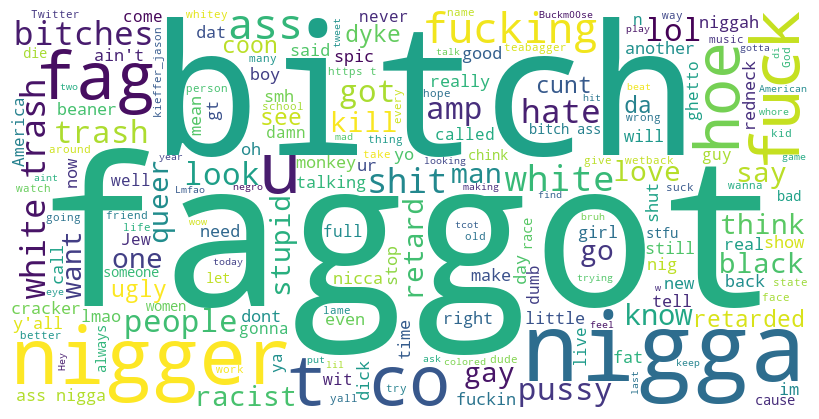

In [8]:
generate_wordcloud(df[df['class'] == 0]['tweet'])

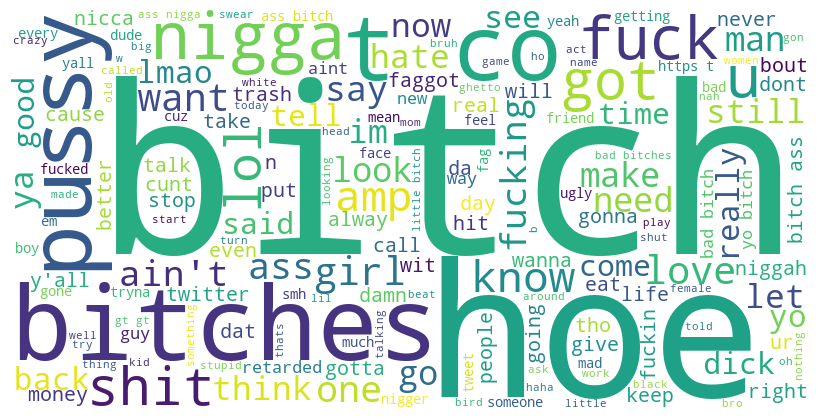

In [9]:
generate_wordcloud(df[df['class'] == 1]['tweet'])

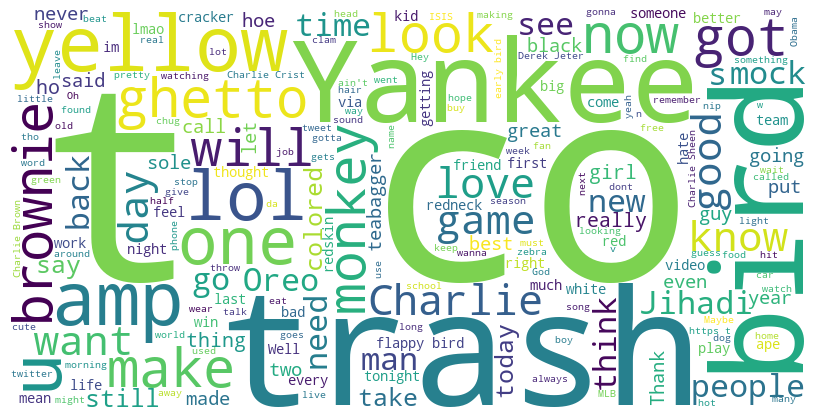

In [10]:
generate_wordcloud(df[df['class'] == 2]['tweet'])

In [11]:
df[df['class'] == 0]['tweet']

85       "@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1...
89       "@CB_Baby24: @white_thunduh alsarabsss" hes a ...
110      "@DevilGrimz: @VigxRArts you're fucking gay, b...
184      "@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL...
202      "@NoChillPaz: "At least I'm not a nigger" http...
                               ...                        
24576                  this guy is the biggest faggot omfg
24685    which one of these names is more offensive kik...
24751           you a pussy ass nigga and I know it nigga.
24776                                   you're all niggers
24777    you're such a retard i hope you get type 2 dia...
Name: tweet, Length: 1430, dtype: object

In [12]:
# refer to the help of kaggle
def clean_text(text):
    # Convert all text to lower case. This is to maintain uniformity and avoid duplicacy over case difference.
    text = str(text).lower()

    # Remove text inside square brackets. This can help get rid of any unwated data enclosed in these brackets.
    text = re.sub('\[.*?\]', '', text)

    # Remove urls. URLs are usually not informative in text classification tasks.
    text = re.sub('https?://\S+|www\.\S+', '', text)

    # Remove html tags. Again, they carry less to no information for text classification.
    text = re.sub('<.*?>+', '', text)

    # Remove punctuations. This will help us reduce the complexity of data and the size of the vocabulary.
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    # Replace newline characters with space. For text analysis, we usually treat text data as a single line.
    text = re.sub('\n', '', text)

    # Remove digits and words containing digits. We are assuming here that digits do not carry any sentiment.
    # But in real time, it might be a problem since some combinations of digits might have meanings.
    text = re.sub('\w*\d\w*', '', text)

    # Remove stopwords. Stop words are commonly used words that are less informative and are usually removed.
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)

    # Apply stemming. Stemming is the process of reducing a word to its word stem, base or root form.
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)

    # Return the cleaned text
    return text


# Proposed Solution

As our initial "default" algorithm, we will use logistic regression to classify tweets into two binary classes, offensive/hate (positive class) or clean (negative class).  

We start with getting the necessary columns from our dataset, and then changing the classes of each tweet to represent our binary system. Along with cleaning up the text data from the tweets.

In [13]:
tweets = df['tweet']
tweet_class = df['class']

tweet_class = np.where(tweet_class == 0, 1, tweet_class)
tweet_class = np.where(tweet_class == 2, 0, tweet_class)

# data preprocessing
tweets = df['tweet'].apply(clean_text)

X = tweets
Y = tweet_class

Now that we have X and Y arrays, we use sklearns splitting function to create training and testing data

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y)

In the next few steps we do some very important transformations to our text data. We need to somehow convert our strings from text data into some numerical data that maintains information. We will use the TF-IDF algorithm to do this, thankfully sklearn has some built in features to do this. Also notice that we will use some technique to help with the imbalance data issue later.

First we utilize sklearn's CountVectorizer. Which takes in a collection of strings, in this case training data, and creates a matrix containing the counts of each word. Each row of this matrix contains a count for each word seen in the whole collection, and represents one string from the collection.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english', ngram_range=(1,5))

x_train_vectorizer=count.fit_transform(x_train)

x_test_vectorizer=count.transform(x_test)
x_train_vectorizer.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Now we use our "count vectorized" data set and apply sklearn's TF-IDF transformer. TF-IDF calculates the importance of specific words by comparing its frequency in that tweet compared to its frequency in the whole collection.

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()

x_train_tfidf = tfidf.fit_transform(x_train_vectorizer)

x_train_tfidf.toarray()
x_test_tfidf = tfidf.transform(x_test_vectorizer)

Now that we have converted our text data into something numerical, we can finally apply logistic regression

In [17]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_train_tfidf, y_train)

LogisticRegression()

# Evaluation Metrics

In the context of our problem statement, precision is an essential metric because we are highly concerned about minimizing false positives. In this case, a false positive would mean our model wrongly classifies a tweet as hate speech or offensive language, potentially leading to an undeserved ban or flag for the user. This could have significant consequences for the user experience and the overall trust in the platform. Therefore, we aim to maximize the precision of our model.

### Precision

Precision, also known as the positive predictive value, quantifies the model's ability to avoid labeling non-hateful or non-offensive tweets as hateful or offensive. Mathematically, precision is defined as the ratio of true positives (TP) to the sum of true positives and false positives (FP):

Precision = TP / (TP + FP)

Where:
- TP = True Positives: The instances where the model correctly predicted a tweet as hate speech or offensive language.
- FP = False Positives: The instances where the model incorrectly flagged a non-offensive tweet as offensive or hate speech.

The higher the precision, the lower the false positive rate, and the fewer innocent users will get flagged or banned.

For instance, if our model flags 100 tweets as offensive, and 85 of them are indeed offensive, the precision of our model would be 85/100 = 0.85 or 85%. This implies that 85% of the users flagged by the system as offensive were correctly identified.

However, precision alone may not provide the full picture of our model's performance. It does not consider false negatives (actual offensive tweets that the model failed to flag), which are also a concern. To get a more comprehensive understanding, we might consider other metrics like recall or F1 score in conjunction with precision. But given our specific objective of reducing user banning due to misclassification, precision becomes our primary metric.

Thus, while building the model, we aim to maximize precision to ensure that the users are not wrongly flagged or banned due to the misclassification of their tweets as hate speech or offensive language.


# Preliminary results

In [18]:
from sklearn.metrics import accuracy_score

y_pred = logreg.predict(x_test_tfidf)

accuracy_score(y_test, y_pred)

0.9147837314396384

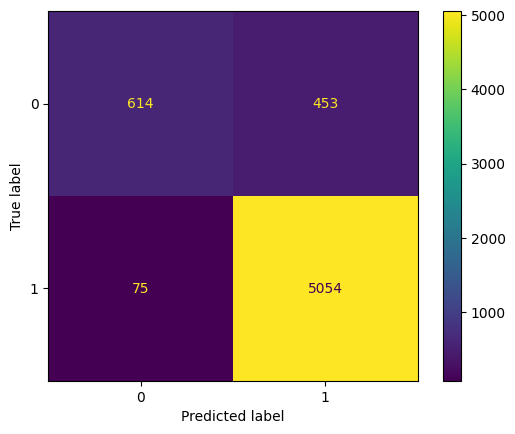

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()


In [20]:
from sklearn.metrics import classification_report
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.58      0.70      1067
           1       0.92      0.99      0.95      5129

    accuracy                           0.91      6196
   macro avg       0.90      0.78      0.82      6196
weighted avg       0.91      0.91      0.91      6196



Our initial results look pretty good for such a simple algorithm, but there are some issues. Since our data set is unbalanced, our count of true negatives vs false negatives is pretty close, which heavily reduces our recall for negatives cases. This imbalance seems to be the cause for most of our error, but it could be reduced by possibly using more complex models.

In [21]:
x_sample = pd.Series(["hello my name is sole", "hello my name is john", "sole", "damn sole", "I hate sole as a person"])

x_sample = x_sample.apply(clean_text)

x_sample_vectorizer = count.transform(x_sample)

x_sample_tfidf = tfidf.transform(x_sample_vectorizer)

print(logreg.predict(x_sample_tfidf))

[0 1 0 0 0]


After playing with the classifier above, I noticed that it is very quick to mark new data as offensive, and almost seems to search for keywords to mark a string as clean. By the example above, I found it really likes the word "sole", as it seemed to mark my second string as offensive. This continued just for the string "sole", but it did prioritize an offensive word in my 4th string over "sole", which seems to suggest it does value words differently. We can see this from the opposite direction in my 5th string, which doesn't contain any offensive words by themselves, but has a hateful meaning, and is marked accordingly.

In conclusion, I think a logistic classifier could be used, but it would require a much more balanced dataset. Going from here, we can attempt to use other models and see how they work on our dataset as is, or attempt to balance our data by either getting more classified clean tweets, or by just training our model on known clean text from various sources.

# Ethics & Privacy

Considering that we are going to classify whether or not a tweet is hateful or offensive, there may be ethical concerns. Firstly, if the classifier were to perform inaccurately it can cause harm to many people. For example, if it classifies a tweet that is not hateful as hateful, then it can impede on someone's freedom of speech. Second, if it classifies a tweet that is hateful that is not hateful, it can damage a person's mental wellbeing. Our team plans to prioritize reducing misses over false alarms in order to protect the mental health of the users at scale. Contrastingly, because the tweets are posted to the public we are not concerned with privacy issues. Given that our data is unevenly distributed and has more tweets that are labeled as offensive, our model may be biased toward offensive classifications. This may over classify non-offensive tweets and limit freedom of speech. We are planning to divide the data evenly during training and testing and potentially enlarge the minority classes to minimize bias.

# Team Expectations 

* *Our team will communicate in a kind, direct, and respectful manner with each other either over text or in person in all aspects of the project*
* *Our team will equally and fully contribute to all aspects of the project in order to be turned in before the deadline*
* *Our team will be honest in all aspects of the project*
* *On-time attendance is required in each team meeting*
* *In the case of an absence, 24 hour notice of meeting cancellation is required *


# Project Timeline Proposal

| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 5/9  |  4 PM | NA  | Ideate and choose project, divide and conquer project proposal | 
| 5/17  |  Before 8 PM | Team members complete their assigned parts | Proposal Due  | 
| 5/24  | Before 8 PM  | Team members complete peer review individually | Peer Review Due   |
| 5/30 | 4 PM  | Team members review peer feedback | Start project with feedback, prep data, divide work, complete checkpoint |
| 5/31  | Before 8 PM  | Team members complete their assigned parts| Checkpoint Due |
| 6/5  | 7 PM  | NA | Plan remaining work for training & testing, Divide and Conquer  |
| 6/14  | Before 8 PM  | Team members finish final details | Final Project Due  |

# Footnotes
<a name="brownnote"></a>1.[^](#brown): Brown, Alexander. “What Is so Special about Online (as Compared to Offline) Hate Speech?” Ethnicities, vol. 18, no. 3, 2018, pp. 297–326. JSTOR, https://www.jstor.org/stable/26497929. Accessed 18 May 2023. <br>
<a name="ulgennote"></a>2.[^](#ulgen): Ülgen, Sinan. “FREEDOM OF EXPRESSION ONLINE.” GOVERNING CYBERSPACE: A Road Map for Transatlantic Leadership, Carnegie Endowment for International Peace, 2016, pp. 17–28. JSTOR, http://www.jstor.org/stable/resrep26924.7. Accessed 18 May 2023.<br>
<a name="chatgptnote"></a>3.[^](#chatgpt): ChatGPT, OpenAI. Personal communication for technical assistance, formatting, and provision of sample code. May 2023.

